## Identifying Entities in Healthcare Data

In [ ]:
#pip install spacy

In [ ]:
#pip install sklearn-crfsuite

In [ ]:
#pip install --upgrade scikit-learn sklearn-crfsuite

In [1]:
# Library Import
import pandas as pd
import re
import spacy
import warnings
warnings.filterwarnings('ignore')

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

### Pre-Processing

**We need to pre-process the data to recover the complete sentences and their labels.**

### Construct the proper sentences from individual words

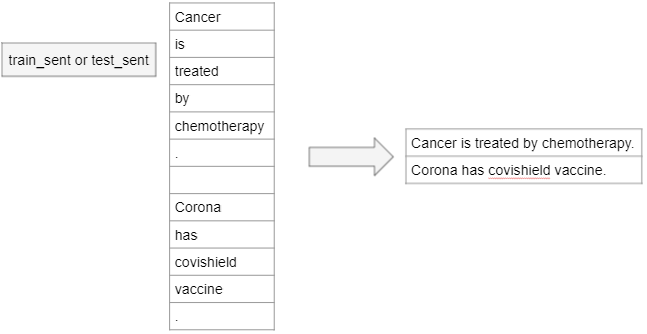

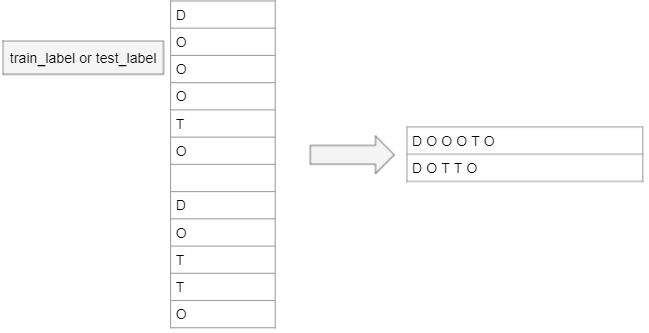

#### As you are already aware that the dataset is in the token format instead of sentences, you need to construct the sentences from the words

In [2]:
def fileProcessing(filename):
  input_file = open(filename, 'r')
  file_content = input_file.readlines() 
  input_file.close()

  out_lines = [] # fpr storing lsit of sequences

  line_content = ""

  for word in file_content:
    word = word.strip() 
    if word == "": # If blank add the current sequence to out_lines
      out_lines.append(line_content)
      line_content = ""; 
    else:
      if line_content: # if not blank add new word after space
        line_content += " "+word
      else:
        line_content = word # 1st word

  return out_lines

In [3]:
train_sentences = fileProcessing('train_sent')
train_labels = fileProcessing('train_label')
test_sentences = fileProcessing('test_sent')
test_labels = fileProcessing('test_label')

In [4]:
# Print few sentences to validate
for i in range(10):
  print("Sentence:", train_sentences[i])
  print("Labels:", train_labels[i], "\n\n")

Sentence: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Labels: O O O O O O O O O O O O O O O 


Sentence: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence: Arrest of dilation was the most common indication in both `` co

### Lets take the counts now!!

In [5]:
print("# lines in train_sentences:", len(train_sentences))
print("# lines in test_sentences:", len(test_sentences))

# lines in train_sentences: 2599
# lines in test_sentences: 1056


In [6]:
print("# lines in train_labels:", len(train_labels))
print("# lines in test_labels:", len(test_labels))
     

# lines in train_labels: 2599
# lines in test_labels: 1056


## Concept Identification

After preprocessing, we will first explore what are the various concepts present in the dataset. For this task, we will use PoS tagging. It is good to identify all the words from the corpus that have a tag of NOUN or PROPN (nouns) and prepare a dictionary of their counts. We will then output the top 25 most frequently discussed concepts in the entire corpus.

 

An important point to note here is that we are using both test and train sentences for concept identification. This is an exploratory analysis on the complete data. In this step, you need to perform the following two tasks by considering the train and the test dataset as a single unit of data:

Use a toolkit like spaCy to extract those tokens that have NOUN or PROPN as their PoS tag and find their frequency from the entire dataset that comprises both the train and the test datasets.
Print the top 25 most common tokens with NOUN or PROPN PoS tags for the entire dataset that comprises both the train and the test datasets.

#### Extract tokens - NOUN or PROPN as their PoS tag. Also find the frequency

In [7]:
import sklearn_crfsuite
model = spacy.load("en_core_web_sm")

In [8]:

concepts = {}

for sentences in (train_sentences, test_sentences):
  for sentence in sentences:
    analyzed_sentence = model(sentence) # Analyze each sentence using spacy 
    for token in analyzed_sentence:
      if(token.pos_ == 'NOUN' or token.pos_ == 'PROPN'): #check if noun
        concepts[token.text] = concepts.get(token.text, 0) + 1; #frequency+1 if noun

### output the top 25 most frequently discussed concepts in the entire corpus.

In [9]:
from collections import Counter

concept_counter = Counter(concepts)
concept_counter.most_common(25)

[('patients', 492),
 ('treatment', 281),
 ('%', 247),
 ('cancer', 200),
 ('therapy', 175),
 ('study', 154),
 ('disease', 142),
 ('cell', 140),
 ('lung', 116),
 ('group', 94),
 ('chemotherapy', 88),
 ('gene', 87),
 ('effects', 85),
 ('results', 79),
 ('women', 77),
 ('use', 74),
 ('TO_SEE', 74),
 ('risk', 71),
 ('cases', 71),
 ('surgery', 71),
 ('analysis', 70),
 ('rate', 67),
 ('response', 66),
 ('survival', 65),
 ('children', 64)]

## Defining features for CRF

Perform these steps:
1. Define the features with the PoS tag as one of the features.1. 
While defining the features in which you have used the PoS tags, you also need to consider the preceding word of the current word. The use of the information of the preceding word makes the CRF model more accurate and exhaustive.1. 
Mark the beginning and the end words of a sentence correctly in the form of features.

In [10]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  #Define 12 features with PoS tag as one of the features
  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos]
  ]

  #Use the previous word also while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  # Mark the begining and the end words of a sentence correctly in the form of features.
  else:
    features.append('BEG') # track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # track end of sentence

  return features

## Getting the features and the labels of sentences:

#### Function to retrieve the features in a sentence

In [11]:
# fun to retrieve the features in a sentence
def getFeaturesForOneSentence(sentence):
  
  processed_sentence = model(sentence)   
  pos_tags = [] # identifying pos tags
  for token in processed_sentence:
    pos_tags.append(token.pos_)

  sentence_list = sentence.split() # List of words in sentence
  
  #Correctly calling getFeaturesForOneWord defined above
  return [getFeaturesForOneWord(sentence_list, pos, pos_tags) for pos in range(len(sentence_list))]

#### Function to retrieve the labels in a sentence

In [12]:
# fun to retrieve the labels in a sentence
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Defining input and target variables

X and Y part below!

In [13]:
# X_train and X_test
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

In [14]:
# Y_train and Y_test
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

## Building the model

#### WE will be building a CRF model

In [15]:
# Build the CRF model.
import sklearn_crfsuite

# Calling CRF 
crf = sklearn_crfsuite.CRF(max_iterations=100)

# Check that only X_train and Y_train are passed
try:
    crf.fit(X_train, Y_train)
except AttributeError: # Added this piece of code due to AttributeError:
    pass



## Evaluation

* Predict the labels of each of the tokens in each sentence of the test dataset that has been preprocessed earlier.* 
Calculate the f1 score using the actual and the predicted labels of the test dataset.

In [16]:
Y_pred = crf.predict(X_test)

#### Calculating the f1 score

In [18]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100,2)))

Predicted F1-score for Medical Entity Dataset is: 90.53 % 


## Identifying the diseases and treatment using a custom NER: 

#### Create the code or logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset. You can refer to the following image to get an idea on how to create a dictionary where diseases are working as keys and treatments are working as values.

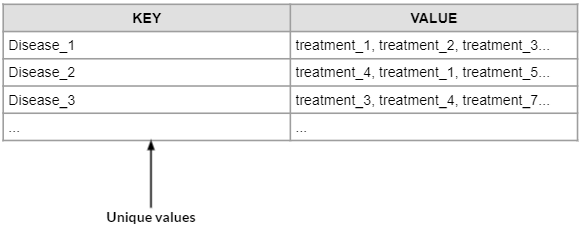

#### Predict the treatment for the disease named 'hereditary retinoblastoma'.

In [19]:
# lets try implementing above

diseases_treatments =  {} # dictionary - Key: disease, value:treatments

for i in range(len(Y_pred)): # For each sequence
  labels = Y_pred[i]

  disease = "";
  treatment = "";
  
  for j in range(len(labels)): # for each label in the sequence
    if labels[j] == 'O': # ignore if label is O -- other
      continue

    if(labels[j] == 'D'): # D indicates disease
      disease += test_sentences[i].split()[j] + " "
      continue

    if(labels[j] == 'T'): # T indicates treatment
      #print(test_sentences[i].split()[j])
      treatment += test_sentences[i].split()[j] + " "

  disease = disease.strip() 
  treatment = treatment.strip()

  # Identified Diseases and Treaments goes to Dict. If its a new Disease, we can add it instantly, if not then we need to get the treatments
  # and add to lsit of already existing treatments 
  if disease is not "" and treatment is not "":
    if disease not in diseases_treatments.keys():
      diseases_treatments[disease] = [treatment]
    else:
      treatment_list = diseases_treatments.get(disease)
      treatment_list.append(treatment)
      diseases_treatments[disease] = treatment_list 
     

In [20]:
# Try printing dict
diseases_treatments


{'hereditary retinoblastoma': ['radiotherapy'],
 'myocardial infarction': ['warfarin with 80 mg aspirin , or 1 mg warfarin with 80 mg aspirin'],
 'unstable angina': ['roxithromycin'],
 'coronary-artery disease': ['Antichlamydial antibiotics'],
 'primary pulmonary hypertension ( PPH )': ['fenfluramines'],
 'foot infection': ['G-CSF treatment'],
 "early Parkinson 's disease": ['Ropinirole monotherapy'],
 'sore throat': ['Antibiotics'],
 'abdominal tuberculosis': ['steroids'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension )': ['intrauterine insemination with donor sperm versus intrauterine insemination'],
 'cancer': ['organ transplantation and chemotherapy',
  'oral drugs chemotherapy'],
 'major pulmonary embolism': ['Thrombolytic treatment right-side hemodynamics'],
 'malignant pleural mesothelioma': ['chemotherapy'],
 'tumor markers pulmonary symptoms': ['chemotherapy'],
 'non-obstruc

#### Improving the readability - converting to dataframe

In [21]:
# Converting to dataframe
cleaned_df = pd.DataFrame({"Disease":diseases_treatments.keys(),"Treatments":diseases_treatments.values()})
cleaned_df.head(10)

,Disease,Treatments
0,hereditary retinoblastoma,[radiotherapy]
1,myocardial infarction,"[warfarin with 80 mg aspirin , or 1 mg warfari..."
2,unstable angina,[roxithromycin]
3,coronary-artery disease,[Antichlamydial antibiotics]
4,primary pulmonary hypertension ( PPH ),[fenfluramines]
5,foot infection,[G-CSF treatment]
6,early Parkinson 's disease,[Ropinirole monotherapy]
7,sore throat,[Antibiotics]
8,abdominal tuberculosis,[steroids]
9,female stress urinary incontinence,[surgical treatment]


#### Prediction for or the disease named 'hereditary retinoblastoma'.

In [22]:
def print_treatments(lookup_disease):
    # Lookup the treatments for the given disease
    treatments = diseases_treatments[lookup_disease]
    
    # Print treatments
    print("Treatments for '{0}' are ".format(lookup_disease), end = "")
    for i in range(len(treatments)-1):
        print("'{}'".format(treatments[i]), ",", end="")
    print("'{}'".format(treatments[-1]))

In [23]:
lookup_disease = 'hereditary retinoblastoma'
print_treatments(lookup_disease)

Treatments for 'hereditary retinoblastoma' are 'radiotherapy'


#### Additional testing

In [24]:
lookup_disease = 'advanced stage ( TNM IIB-IVB ) mycosis'
print_treatments(lookup_disease)

Treatments for 'advanced stage ( TNM IIB-IVB ) mycosis' are 'a combination chemotherapy program consisting of bleomycin and methotrexate weekly , doxorubicin every'
